In [3]:
using Pkg
cd("/home/alan/NTRsurv.jl")   # go to package root
Pkg.activate(".") 
Pkg.instantiate()

  Activating project at `~/NTRsurv.jl`
Precompiling packages...
   1457.8 ms  ✓ NTRsurv
  1 dependency successfully precompiled in 2 seconds. 105 already precompiled.


In [4]:
using Revise

In [5]:
# Load packages
using NTRsurv, Survival, StatsModels, CSV, DataFrames, Plots, LaTeXStrings, Random
# Set seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [6]:
# Load data 
tongue = CSV.read(joinpath(pkgdir(NTRsurv), "examples", "data", "tongue.csv"), DataFrame)
T = float.(tongue[!,:time])
δ = tongue[!,:delta];

In [7]:
# Fit Kaplan-Meier estimator for survival curve
km = fit(KaplanMeier, T, δ)

KaplanMeier{Float64, Float64}(EventTable{Float64}([1.0, 3.0, 4.0, 5.0, 8.0, 10.0, 12.0, 13.0, 16.0, 18.0  …  129.0, 131.0, 150.0, 157.0, 167.0, 176.0, 181.0, 231.0, 240.0, 400.0], [2, 3, 2, 2, 1, 1, 1, 3, 2, 1  …  1, 0, 0, 1, 1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 1, 1, 0, 0, 1, 0, 2, 1, 1], [80, 78, 75, 73, 71, 69, 68, 67, 64, 62  …  11, 10, 9, 8, 7, 6, 5, 4, 2, 1]), [0.975, 0.9375, 0.9125000000000001, 0.8875000000000001, 0.8750000000000001, 0.8623188405797103, 0.8496376811594205, 0.8115942028985509, 0.7862318840579712, 0.7735507246376814  …  0.2883605848313903, 0.2883605848313903, 0.2883605848313903, 0.2523155117274665, 0.21627043862354273, 0.21627043862354273, 0.1730163508988342, 0.1730163508988342, 0.1730163508988342, 0.1730163508988342], [0.01790287185098582, 0.028867513459481287, 0.034621238235890715, 0.03980586693257064, 0.042257712736425826, 0.04470842219836276, 0.04709919104246099, 0.05401815123202459, 0.058497802698822765, 0.06071575813144969  …  0.2129794971

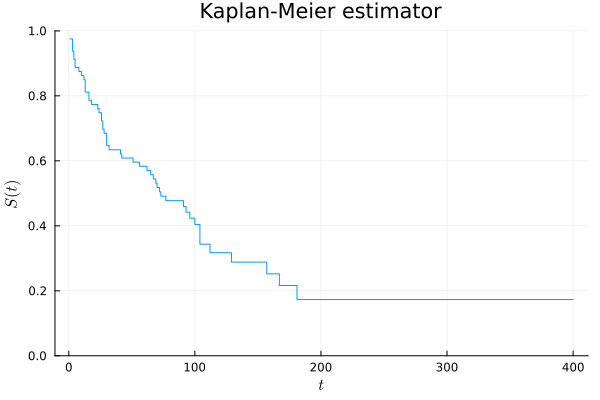

In [8]:
# Plot of Kaplan-Meier estimator
plot(km.events.time,km.survival, seriestype = :steppost, xlabel = L"t", ylabel = L"S(t)", label = "", ylim=(0,1), title="Kaplan-Meier estimator")

In [9]:
# Create NTRsurv structures
α₀ = 1.0
data_NTR = DataNTR(T,δ)
baseline_info = EmpBayesBaseline(data_NTR)

BaselineNTR(NTRsurv.var"#ExponentialBaseline##0#ExponentialBaseline##1"{Float64}(0.01729490022172949), NTRsurv.var"#ExponentialBaseline##2#ExponentialBaseline##3"{Float64}(0.01729490022172949), NTRsurv.var"#ExponentialBaseline##4#ExponentialBaseline##5"{Float64}(0.01729490022172949))

In [10]:
println("The baseline mean is ", 1/0.02)

The baseline mean is 50.0


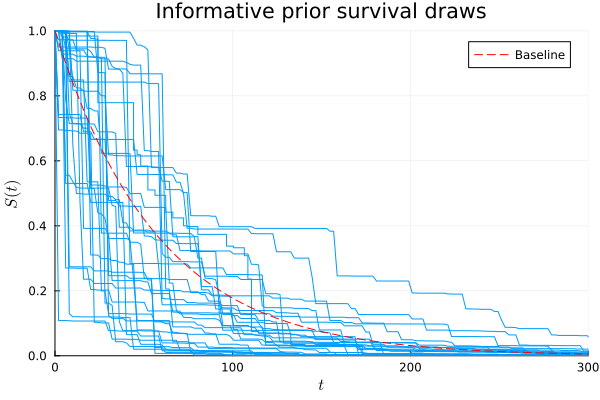

In [11]:
# Plotting time grid
t =  collect(LinRange(0.0,400,200));
# Plot a priori survival draws
prior_plt = plot(t,prior_sim(t,α₀,baseline_info),seriestype = :steppost, xlabel = L"t", ylabel = L"S(t)", label = "", xlim=(0,300), ylim=(0,1), title="Informative prior survival draws")
for i in 1:29
    plot!(t,prior_sim(t,α₀,baseline_info),c=1,label="")
end
plot!(t,exp.(-baseline_info.κ.(t)),c=:red, linestyle=:dash, label="Baseline")
prior_plt

In [12]:
τ = data_NTR.T

59-element Vector{Float64}:
   1.0
   3.0
   4.0
   5.0
   8.0
  10.0
  12.0
  13.0
  16.0
  18.0
  23.0
  24.0
  26.0
   ⋮
 112.0
 120.0
 129.0
 131.0
 150.0
 157.0
 167.0
 176.0
 181.0
 231.0
 240.0
 400.0

In [13]:
t

200-element Vector{Float64}:
   0.0
   2.0100502512562812
   4.0201005025125625
   6.030150753768844
   8.040201005025125
  10.050251256281408
  12.060301507537687
  14.07035175879397
  16.08040201005025
  18.090452261306535
  20.100502512562816
  22.110552763819097
  24.120603015075375
   ⋮
 377.8894472361809
 379.8994974874372
 381.9095477386935
 383.91959798994975
 385.929648241206
 387.9396984924623
 389.9497487437186
 391.9597989949749
 393.96984924623115
 395.9798994974874
 397.9899497487437
 400.0

In [14]:
function mesh_assign(t, τ, δ)
    i = 1
    j = 1
    n = length(t)
    k = length(τ)
    m  = Vector{eltype(t)}(undef, n + k)
    mδ  = Vector{Int}(undef, n + k)
    r = 1
    @inbounds while i ≤ n && j ≤ k
        if t[i] < τ[j]
            m[r] = t[i]
            mδ[r] = 0
            i += 1
        elseif t[i] > τ[j]
            m[r] = τ[j]
            mδ[r] = δ[j]
            j += 1
        else
            # duplicate → keep τ version
            m[r] = τ[j]
            mδ[r] = δ[j]
            i += 1
            j += 1
        end
        r += 1
    end
    @inbounds while i ≤ n
        m[r] = t[i]
        mδ[r] = 0
        i += 1
        r += 1
    end
    @inbounds while j ≤ k
        m[r] = τ[j]
        mδ[r] = δ[j]
        j += 1
        r += 1
    end
    return m[1:r-1], mδ[1:r-1]
end

mesh_assign (generic function with 2 methods)

In [15]:
bla = mesh_assign( t, τ, data_NTR.δ)

([0.0, 1.0, 2.0100502512562812, 3.0, 4.0, 4.0201005025125625, 5.0, 6.030150753768844, 8.0, 8.040201005025125  …  383.91959798994975, 385.929648241206, 387.9396984924623, 389.9497487437186, 391.9597989949749, 393.96984924623115, 395.9798994974874, 397.9899497487437, 400.0, 4.53929808e-315], [0, 1, 0, 1, 1, 0, 1, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
NTR_band_d_prior, NTR_band_m_prior, NTR_band_u_prior = cred_band(0.05,3000,t,α₀, baseline_info)

LoadError: UndefVarError: `baseline_info` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [11]:
plot(t, NTR_band_m_prior,  ribbon = (NTR_band_m_prior .- NTR_band_d_prior, NTR_band_u_prior .- NTR_band_m_prior), fillalpha=0.3, label="Posterior NTR mean \n with 95% credible band",size=(600,400))
plot!(km.events.time,km.survival, seriestype = :steppost, xlabel = "t", ylabel = "S(t)", label = "Kaplan-Meier estimator", ylim=(-0.025,1), title="Informative pior for the tail")
plot!(t,exp.(-baseline_info.κ.(t)),c=:red, linestyle=:dash, label="Baseline")

LoadError: UndefVarError: `NTR_band_m_prior` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [76]:
model_NTR_info = ModelNTR(α₀,baseline_info,data_NTR)

NTRsurv.ModelNTRrep(1.0, 1.4426950408889634, BaselineNTR(NTRsurv.var"#ExponentialBaseline##0#ExponentialBaseline##1"{Float64}(0.01729490022172949), NTRsurv.var"#ExponentialBaseline##2#ExponentialBaseline##3"{Float64}(0.01729490022172949), NTRsurv.var"#ExponentialBaseline##4#ExponentialBaseline##5"{Float64}(0.01729490022172949)), NTRsurv.DataNTRrep([1.0, 3.0, 4.0, 5.0, 8.0, 10.0, 12.0, 13.0, 16.0, 18.0  …  129.0, 131.0, 150.0, 157.0, 167.0, 176.0, 181.0, 231.0, 240.0, 400.0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 0, 0, 1, 1, 0, 1, 0, 0, 0], 59, [2, 3, 2, 2, 1, 1, 1, 3, 2, 1  …  1, 0, 0, 1, 1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 1, 1, 0, 0, 1, 0, 2, 1, 1], [80, 78, 75, 73, 71, 69, 68, 67, 64, 62  …  10, 9, 8, 7, 6, 5, 4, 2, 1, 0], [78, 75, 73, 71, 70, 68, 67, 64, 62, 61  …  10, 9, 7, 6, 6, 4, 4, 2, 1, 0]))

In [77]:
NTR_band_d_info, NTR_band_m_info, NTR_band_u_info = cred_band(0.05,3000,t,model_NTR_info)

([1.0, 0.8881675850553321, 0.7927907166849922, 0.7478636161885848, 0.74255154926286, 0.732667934996181, 0.7068314242135446, 0.665277493126141, 0.6229679953038089, 0.6184293510844016  …  8.334570061485243e-83, 2.4865607172230294e-84, 8.491342108103041e-85, 1.678021413399317e-85, 8.278862588287802e-87, 2.9865332612580563e-87, 3.813125462845161e-89, 6.544251197303557e-91, 1.0429617006454479e-91, 4.633278528925891e-93], [1.0, 0.9748877019702613, 0.9128282509506818, 0.88727985776978, 0.8736916505141654, 0.8605387537257129, 0.8471921264902642, 0.8101689076593606, 0.7833659423110141, 0.7696464498841641  …  2.593672310845374e-58, 1.9584408357166845e-59, 7.596926189408047e-60, 1.0644587476428537e-60, 1.0269637067451078e-61, 1.127795845797905e-62, 3.100006263901583e-63, 1.0894607220718588e-63, 6.741347610880234e-64, 3.455800005522617e-64], [1.0, 0.9998489695051744, 0.9851003715563277, 0.9759713288863273, 0.9664663398280887, 0.9516765792371686, 0.9470838620168233, 0.9230504369642103, 0.8966874675

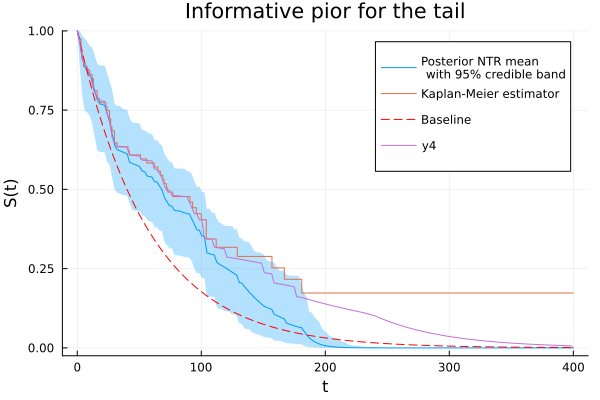

In [80]:
plot(t, NTR_band_m_info,  ribbon = (NTR_band_m_info .- NTR_band_d_info, NTR_band_u_info .- NTR_band_m_info), fillalpha=0.3, label="Posterior NTR mean \n with 95% credible band",size=(600,400))
plot!(km.events.time,km.survival, seriestype = :steppost, xlabel = "t", ylabel = "S(t)", label = "Kaplan-Meier estimator", ylim=(-0.025,1), title="Informative pior for the tail")
plot!(t,exp.(-baseline_info.κ.(t)),c=:red, linestyle=:dash, label="Baseline")
plot!(t, postmeansurv(t,model_NTR_info))

In [ ]:
#savefig("InfTailTongueData.png")

For a flatter tail behaviour we can select a more non-informative baseline

In [39]:
baseline2 = ExponentialBaseline(0.001);

In [40]:
println("The baseline mean is ", 1/0.001)

The baseline mean is 1000.0


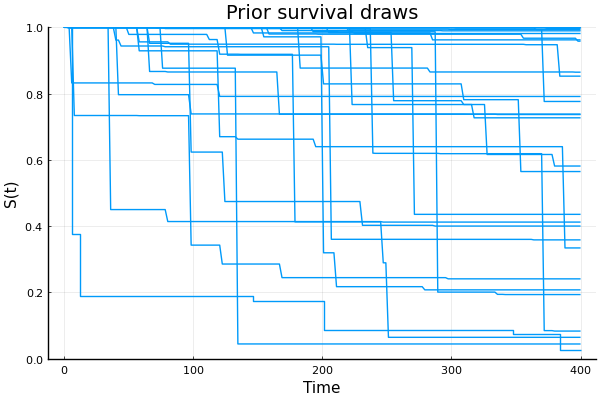

In [41]:
prior_plt_2 = plot(t,prior_sim(t,1.0,baseline2),seriestype = :steppost, xlabel = "Time", ylabel = "S(t)", label = "", ylim=(0,1), title="Prior survival draws")
for i in 1:29
    plot!(t,prior_sim(t,1.0,baseline2),c=1,label="")
end
prior_plt_2

In [42]:
# Set NTR models
model_NTR2 = ModelNTR(1.0,baseline2,data_NTR)

NTRsurv.ModelNTRrep(1.0, 1.4426950408889634, BaselineNTR(NTRsurv.var"#ExponentialBaseline##0#ExponentialBaseline##1"{Float64}(0.001), NTRsurv.var"#ExponentialBaseline##2#ExponentialBaseline##3"{Float64}(0.001)), NTRsurv.DataNTRrep([1.0, 3.0, 4.0, 5.0, 8.0, 10.0, 12.0, 13.0, 16.0, 18.0  …  129.0, 131.0, 150.0, 157.0, 167.0, 176.0, 181.0, 231.0, 240.0, 400.0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 0, 0, 1, 1, 0, 1, 0, 0, 0], 59, [2, 3, 2, 2, 1, 1, 1, 3, 2, 1  …  1, 0, 0, 1, 1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 1, 1, 0, 0, 1, 0, 2, 1, 1], [80, 78, 75, 73, 71, 69, 68, 67, 64, 62  …  10, 9, 8, 7, 6, 5, 4, 2, 1, 0], [78, 75, 73, 71, 70, 68, 67, 64, 62, 61  …  10, 9, 7, 6, 6, 4, 4, 2, 1, 0]))

In [43]:
# Create credible bands with l posterior siulations
l = 3000
S_NTR2 = zeros(Float64, length(t), l)
for i in 1:l
    S_NTR2[:,i] = posterior_sim(t,model_NTR2)
end
cred_band_mat_NTR2 = cred_band_mat(S_NTR2, round( Int, l*0.05))

200×2850 Matrix{Float64}:
 1.0        1.0        1.0        1.0       …  1.0        1.0        1.0
 0.96797    0.968567   0.946823   0.940188     0.979436   0.96711    0.967934
 0.953906   0.911246   0.909553   0.91965      0.944715   0.922857   0.930894
 0.942851   0.910608   0.880947   0.909413     0.928293   0.917319   0.919745
 0.929638   0.899865   0.867274   0.886947     0.918395   0.894973   0.871204
 0.914391   0.875917   0.861812   0.881356  …  0.917803   0.886181   0.856763
 0.893704   0.823106   0.857063   0.862527     0.881047   0.845681   0.809985
 0.855812   0.819554   0.840395   0.835933     0.841562   0.789795   0.787948
 0.844753   0.812615   0.834678   0.822691     0.822205   0.730751   0.785997
 0.825215   0.793374   0.826533   0.815819     0.805205   0.730726   0.777502
 0.825215   0.793374   0.826533   0.815819  …  0.805205   0.730726   0.777502
 0.825215   0.793374   0.826533   0.815819     0.805205   0.730726   0.777502
 0.717674   0.729345   0.811916   0.790567 

In [44]:
NTR_band_u2 = [ maximum(cred_band_mat_NTR2[i,:]) for i in 1:length(t)]
NTR_band_d2 = [ minimum(cred_band_mat_NTR2[i,:]) for i in 1:length(t)]
μNTR2 = mean(cred_band_mat_NTR2,dims=2)[1:end];

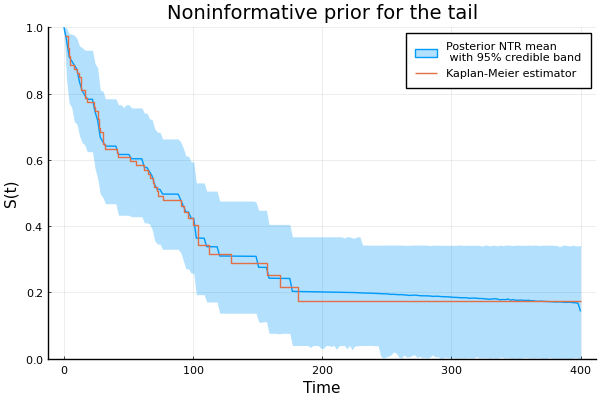

In [45]:
plot(t, μNTR2,  ribbon = (μNTR2 .- NTR_band_d2, NTR_band_u2 .- μNTR2), fillalpha=0.3, label="Posterior NTR mean \n with 95% credible band",size=(600,400))
plot!(km.events.time,km.survival, seriestype = :steppost, xlabel = "Time", ylabel = "S(t)", label = "Kaplan-Meier estimator", ylim=(0,1), title="Noninformative prior for the tail")

In [ ]:
#savefig("NonInfTailTongueData.png")